In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA

## Possible Features
1. hour
1. day
1. month
1. season

1. weekday/weekend
1. ggf. holyday

1. temperature
1. precipitation

In [4]:
# get bikesharing data
chicago_data = pd.read_csv("prepared_data.csv",parse_dates=["start_time","end_time"])
chicago_data.head(1)

,Unnamed: 0,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,duration
0,0,2016-03-31 23:53:00,2016-04-01 00:07:00,344,458,Ravenswood Ave & Lawrence Ave,Broadway & Thorndale Ave,155,Subscriber,14.0


In [13]:
# add month, day, hour and duration
chicago_data["month"] = chicago_data["start_time"].apply(lambda x: x.month)
chicago_data["day"] = chicago_data["start_time"].apply(lambda x: x.day)
chicago_data["hour"] = chicago_data["start_time"].apply(lambda x: x.hour)
chicago_data["duration"] = (chicago_data["end_time"] - chicago_data["start_time"]).astype("timedelta64[m]")
chicago_data.head(1)

,Unnamed: 0,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,duration,hour,month,day
0,0,2016-03-31 23:53:00,2016-04-01 00:07:00,344,458,Ravenswood Ave & Lawrence Ave,Broadway & Thorndale Ave,155,Subscriber,14.0,23,3,31


In [11]:
#get weather
weather = pd.read_csv("weather_hourly_chicago.csv",parse_dates = ["date_time"])
#only keep 2016 data
weather = weather[weather["date_time"].apply(lambda x:x.year == 2016)]
weather = weather.dropna()
#add month, day, hour
weather["month"] = weather["date_time"].apply(lambda x:x.month)
weather["day"] = weather["date_time"].apply(lambda x:x.day)
weather["hour"] = weather["date_time"].apply(lambda x:x.hour)
weather.sort_values(by="date_time")
weather.head(1)

,date_time,max_temp,min_temp,precip,month,day,hour
8736,2016-01-01 01:00:00,-5.0,-5.0,0.0,1,1,1


In [24]:
#merge weather and bikesharing data
all_data = chicago_data.merge(weather[["max_temp","min_temp","precip","month","day","hour"]],left_on=["month","day","hour"],right_on=["month","day","hour"])
all_data.head(1)

,Unnamed: 0,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,duration,hour,month,day,max_temp,min_temp,precip
0,0,2016-03-31 23:53:00,2016-04-01 00:07:00,344,458,Ravenswood Ave & Lawrence Ave,Broadway & Thorndale Ave,155,Subscriber,14.0,23,3,31,12.8,12.8,0.0


In [33]:
# pick feature relevant columns
relevant_columns = all_data[["start_time","month","day","hour","duration","max_temp","precip","bike_id"]]
relevant_columns.sort_values(by="start_time").head()

,start_time,month,day,hour,duration,max_temp,precip,bike_id
397092,2016-01-01 00:07:00,1,1,0,9.0,-4.4,0.0,1094
397091,2016-01-01 00:14:00,1,1,0,11.0,-4.4,0.0,4339
397090,2016-01-01 00:15:00,1,1,0,12.0,-4.4,0.0,1190
397088,2016-01-01 00:16:00,1,1,0,8.0,-4.4,0.0,2048
397089,2016-01-01 00:16:00,1,1,0,8.0,-4.4,0.0,1530


In [73]:
# aggregate the samples into hourly chunks
relevant_columns = all_data[["start_time","month","day","hour","duration","max_temp","precip","bike_id"]]
feature_data = relevant_columns.groupby(pd.Grouper(key='start_time',freq='1H')).agg({"month":"mean","day":"mean","hour":"mean","duration":"mean","max_temp":"mean","precip":"mean","bike_id":"count"})
feature_data.rename(columns={"duration":"mean_duration","bike_id":"trips"}, inplace=True)
# deal with null values
feature_data.loc[feature_data["month"].isna(),"month"] = feature_data.index.to_series().apply(lambda x: x.month)
feature_data.loc[feature_data["day"].isna(),"day"] = feature_data.index.to_series().apply(lambda x: x.day)
feature_data.loc[feature_data["hour"].isna(),"hour"] = feature_data.index.to_series().apply(lambda x: x.hour)
feature_data = feature_data.fillna(method="ffill")
feature_data.head(1)

,month,day,hour,mean_duration,max_temp,precip,trips
start_time,,,,,,,
2016-01-01,1.0,1.0,0.0,13.2,-4.4,0.0,25


In [78]:
# add weekday feature
feature_data["isWeekday"] = feature_data.index.to_series().apply(lambda x: 1 if x.dayofweek in [5,6] else 0)

In [79]:
#convert to csv
feature_data.to_csv('prediction_ready.csv')

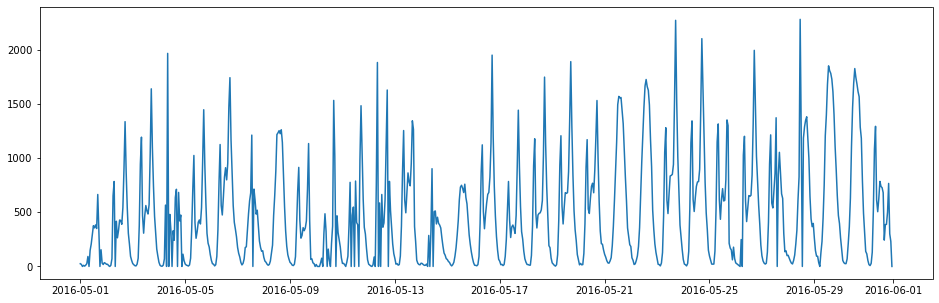

In [85]:
# plot for reassurance
plt.figure(figsize=(16,5))
plt.plot(feature_data[feature_data["month"] == 5].index,feature_data[feature_data["month"] == 5]["trips"])